# Reto técnico Data Scientist [DD360]
## Reto de reseñas

Autor: Daniel A. Armas. <daniel.armas.texta@gmail.com>

## Introducción

El objetivo de este reto es identificar los principales tópicos de los cuales se habla en las reseñas. 

Para lograr dicho objetivo, primero se realizará una limpieza del texto que consta de:

1. llevar el texto a minúsculas
2. eliminar caracteres especiales y signos de puntuación.
3. eliminar acentos y cambiar la 'ñ' por 'ni'.
4. eliminar las 'stopwords'

Una vez terminada la limpieza del texto, continuaremos a generar el vocabulario del _corpus_ (colección de documentos) para posteriormente identificar las **palabras más repetidas**. Con lo anterior, podremos tener un panorama general de los tópicos escondidos en el _corpus_.


Después realizaremos una representación vectorial del texto. En este caso utilizaremos la tecnica de _word embeddings_ la cual nos da una representación vectorial continua y densa del texto, la cual es una gran ventaja pues se puede contralar la dimensionalidad de la matriz resultante y se evitan problemas de matrices dispersas.

Por último, para identificar los tópicos ocuparemos un algoritmo de clusterización para encontrar las asociaciones naturales dentro de los comentarios para agrupar aquellos que hablen del mismo tema y así, por fin, identificar los principales tópicos.

## Librerías

In [1]:
import json
from io import open
import gzip
import numpy as np
import pandas as pd
import datetime
from matplotlib import transforms
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from sklearn.decomposition import PCA
import operator
from mpl_toolkits.mplot3d import axes3d
import nltk, itertools, string, unicodedata, re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import FastText
from wordcloud import WordCloud
import time as tm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import (recall_score, f1_score,
                             precision_score, accuracy_score)
import warnings
warnings.filterwarnings("ignore")


## Funciones

In [2]:
# Preprocesamiento simple para texto
#Eliminar caracteres especiales
def r_ce(text):
    sn=re.sub("[0-9]+", "", text) 
    ce={"?","¿","¡","!",",",".",";",":","-","'","´","\n","*","[","]",
       "(",")","{","}", "/","_","#","@"}
    return "".join(c for c in sn.lower() if c not in ce)

#Elimina URLS #
def r_esp(text):
    return " ".join(re.sub("(https[A-Za-z0-9]+)|(\w+:\/\/\s+)"," ",text).split()) 

#Elimina acentos#
def r_ac(text):
    sin_ac=unicodedata.normalize("NFKD",text)
    return u"".join([c for c in sin_ac if not unicodedata.combining(c)])

#Stop words 
sw=stopwords.words("spanish")
sw.append("w")
sw.append("si")
sw.append("mas")
sw.append("rt")
sw.append("dia")
sw.append("solo")
sw.append("hora")
sw.append("puede")
sw.append("hoy")
sw.append("hace")
sw.append("estan")
sw.append("q")
sw.append("asi")
sw.append("vez")
sw.append("ustede")
sw.append("dicen")

def r_sw(text,sw):
    return " ".join(c for c in text.split() if c not in sw)

#Quitar las "s"
def quita_s(texto):
    palabras=[]
    for x in texto.split():
        if len(x)>3 and x[-1]=="s":
            x_new="".join(i for i in x[:-1])
        else:
            x_new=x
        palabras.append(x_new)
    return " ".join(i for i in palabras)

#Preprocesamiento de texto
def preprocess(text):
    return ((r_sw(r_esp(r_ce(r_ac(quita_s(str(text).replace("ñ","ni"))))),sw)))


In [3]:
#Obtener vocabulario 
def vocabulario_(mensajes):
    texto=" ".join(str(x) for x in mensajes)
    return Counter(preprocess(texto).split())

#Función para generar
def BoW(textos,voc):
    limpio=[]
    for i in textos:
        limpio.append(preprocess(str(i)))
    vector=TfidfVectorizer(vocabulary=voc, token_pattern=r"(?u)\b\w+\b")
    X1=vector.fit_transform(limpio).toarray()
    return X1

In [4]:

#Función para tokenizar tweets
def tokenizar_(lista_tweets,omitir=[]):
    texto_limpio=[]
    for texto in lista_tweets:
        limpiar=preprocess(texto)
        for i in omitir:
            limpiar=limpiar.replace(i,"")
        texto_limpio.append(limpiar.split())
    return np.array(texto_limpio)

#Función para generar modelo de FastText
def modelo_fastext(texto_limpio):
    # definimos el modelo 
    sample_model = FastText(size=300, window=2, min_count=1, min_n=2, max_n=5)
    #construimos el vocabulario
    sample_model.build_vocab(sentences=texto_limpio)
    # Entremanos el modelo
    sample_model.train(sentences=texto_limpio,total_examples=len(texto_limpio), epochs=15)
    print("El modelo se ha entrenado con éxito")
    return sample_model

#Generamos las tweets embeddings
def rep_final(sample_model,texto_limpio,normalizar=True):
    tweets_embeddings=np.array([np.mean([sample_model.wv[token] for token in tweet],axis=0) for tweet in texto_limpio])  
    
    if normalizar==True:
        X_fast=np.array([x/np.linalg.norm(x) for x in tweets_embeddings])
    else:
        X_fast=tweets_embeddings
  
    for i in range(X_fast.shape[0]):
        if np.isnan(X_fast[i].sum()):
            X_fast[i]=np.zeros(sample_model.vector_size)


    return X_fast

# Función para graficar clusters en dos y tres dimensiones
def plotClusters(data,labels,centroids={},f="",centroids_txt_labels={}):
    fig=plt.figure(figsize=(6, 6))
    sbox = dict(boxstyle='round', facecolor='white', alpha=0.4)
    d=len(data[1])
    if d==3:
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = fig.add_subplot(111)
    K=np.unique(labels)
    color_map=iter(cm.viridis(np.linspace(0,1,len(K))))
    for k in K:
        D=data[np.where(labels==k)]
        x,y=D[:,0],D[:,1]
        cl=next(color_map)
        if d==3:
            z=D[:,2]
            ax.scatter(x,y,z, color=cl,s=32)
        else:
            ax.scatter(x,y, color=cl,s=32)
        if len(centroids):
            txt_label=centroids_txt_labels and str(centroids_txt_labels[k]) or str(k)
            if len(centroids[k])==3:
                xc,yc,zc=centroids[k]
                ax.text(xc,yc,zc,txt_label,bbox=sbox,fontsize=14)
            else:
                xc,yc=centroids[k]
                ax.text(xc,yc,txt_label,bbox=sbox,fontsize=14)
    if len(data[0])==3:
        ax.set_zticks([])
    ax.set_xticks([])
    ax.set_yticks([])
    if f:
        fig.savefig(f)

# Transformar datos N>3 dimensionales a 2 o tres dimensiones usando PCA                  
def plotPCA(data, labels, d=2,f="",centroids={},vectors=False,title=""):
    pca = PCA(n_components=d)
    pca.fit(data)
    X=pca.transform(data)
    origin2d=[0],[0]
    origin3d=[0],[0],[0]
    pca_centroids={}
    for k,c in centroids.items():
        pca_centroids[k]=pca.transform([centroids[k]])[0,:]
    plotClusters(X,labels,f=f,centroids=pca_centroids)
    if len(centroids)>0 and vectors:
        for k,c in pca_centroids.items():
            if d==2:
                plt.quiver(*origin2d, pca_centroids[k][0],pca_centroids[k][1],angles='xy',
                        scale_units='xy', scale=1, color='skyblue')
                
            else: 
                plt.quiver(*origin3d, pca_centroids[k][0],pca_centroids[k][1],pca_centroids[k][2],color='skyblue')
    plt.title(title)
    plt.show()

# Obtenemos los tópicos y las nubes de palabras

def topicos_palabras(X_fast,texto_limpio,K_min,omitir=[]):  
  #Calculamos el SSE para diferentes niveles de K para K-Means
    km_sse=[]
    for K in list(range(15))[2:]:
        cluster_model_f=KMeans(n_clusters=K, random_state=42).fit(X_fast)
        km_sse.append(cluster_model_f.inertia_)
    plt.figure(figsize=(8,4))
    plt.plot(list(range(15))[2:],km_sse,label="KMeans")

    plt.title("SSE")
    plt.legend(loc="best")


    plt.grid()
    plt.show()

  # Obtenemos la K óptima tal que
    diff=[]
    for i in range(len(km_sse)-1):
        diff.append(km_sse[i]-km_sse[i+1])

    k=np.array(diff[8:]).argsort()[-1]+3
    if k<=K_min: k=K_min
    print("================ El valor de K es", k, "===================")

  # Generamos el modelo de clusterización con la K óptima
    topicos=KMeans(n_clusters=k, random_state=0).fit(X_fast)

  # Generamos los centroides de los clusters
    centroides={}
    for i in np.unique(topicos.labels_):
        centroides[i]=topicos.cluster_centers_[i]

  # Graficamos los clústers
    plotPCA(X_fast,topicos.labels_,centroids=centroides,d=2,vectors=False,title="Clúster (representación por PCA)")

  #Gracifamos los centroides de los clústers
    labels,vals=list(zip(*centroides.items())) 
    plotPCA(np.array(vals),labels,centroids=centroides,d=2,vectors=True,title="Centroides (representación por PCA)")

  #Graficamos las nubes de palabras por cada clúster
    i=1
    fig=plt.figure(figsize = (30, 25), facecolor = None)
    for k,v in centroides.items():
        ftext=' '.join([' '.join(token) for token in texto_limpio[np.where(topicos.labels_==k)[0]]])
        for j in omitir:
            ftext=ftext.replace(j,"")
        print("Cluster id:%s, Numero de elementos: %s " 
            %(k,texto_limpio[np.where(topicos.labels_==k)].shape[0]))
        wordcloud = WordCloud( background_color ='white', min_font_size = 10).generate(ftext) 
        ax=fig.add_subplot(5,4, i)
        plt.imshow(wordcloud,interpolation="bilinear")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect(1.0)
        i=i+1
    plt.subplots_adjust(hspace=0.1,wspace=0)
    plt.show() 
    return topicos

In [5]:
# Función para imprimir el texto más cercano a cada centroide
def text_topic(data,centroids,top):
    for i in np.unique(data.topicos):
        distancias=[np.linalg.norm(centroids[i]-j) for j in data.embeddings[data.topicos==i]]
        print("\n Reseñas de cluster", i)
        n=1
        for ind in np.array(distancias).argsort()[:top]:
            print(n,str(data.text[data.topicos==i].iloc[ind]))
            n=n+1

## Leemos los datos

In [6]:
data=pd.read_csv("places_reviews.csv",index_col="place_id")
data=data.convert_dtypes()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9183 entries, ChIJ_6PxIP_-0YURb-iv-Yq3gPM to ChIJRU2FLk__0YURikrh-RZMung
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              9183 non-null   string
 1   reviewer         9183 non-null   string
 2   reviewer_avatar  9183 non-null   string
 3   datetime         9183 non-null   string
 4   rating           9183 non-null   Int64 
 5   text             9183 non-null   string
 6   language         9183 non-null   string
 7   id               9183 non-null   string
dtypes: Int64(1), string(7)
memory usage: 654.6+ KB


In [7]:
data=data[data["language"]=="es"].copy()

## Limpiamos el texto y generamos el top 10 de palabras más repetidas

In [8]:
texto_limpio=tokenizar_(data.text)
data["texto_limpio"]=texto_limpio
texto_limpio

array([list(['higiene', 'medida', 'sana', 'distancia', 'excelente', 'calidad', 'alimento', 'maravillosa', 'atencion', 'vale', 'pena']),
       list(['buen', 'lugar', 'comer', 'pasar', 'rato']),
       list(['super', 'delicioso', 'economico', '🥰❤️❤️']), ...,
       list(['rica', 'torta', 'ahogada', '🤤🤤🤤']),
       list(['riquisimo', 'torta', 'ahogada', 'taco', 'dorado', 'taco', 'barbacoa', 'marisco', 'tambien', 'michelada', 'buenisima']),
       list(['perfeccion', 'existe', 'doy', 'estrellas', 'delicioso', 'parecia', 'gdl', 'torta', 'ahogada', 'buenisima', 'jugo', 'carne', 'delicioso', 'deje', 'nun', 'desear', 'gusto', 'barbacoa', 'roja', 'desabrida', 'precio', 'aceptable', 'servicio', 'bueno', 'valet', 'parking'])],
      dtype=object)

In [9]:
vocabulario=vocabulario_(data.text)

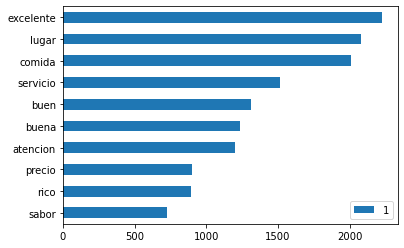

In [10]:
top_palabras=pd.DataFrame(pd.DataFrame(vocabulario.most_common(10)).sort_values(by=1))
top_palabras.plot.barh(x=0,y=1, xlabel="",ylabel="Frecuencias")
plt.show()

Cómo podemos observar, las palabras más frecuentes son "buenas", por lo cual esperamos tener críticas positivas.

## Entrenamos el modelo con el texto limpio del _corpus_

In [11]:
sample_model=modelo_fastext(texto_limpio)

El modelo se ha entrenado con éxito


## Generamos la representación vectorial del texto

In [12]:
X_fast=rep_final(sample_model,texto_limpio,normalizar=True)
data["embeddings"]=list(X_fast)

## Generamos la clusterización para identificar los tópicos

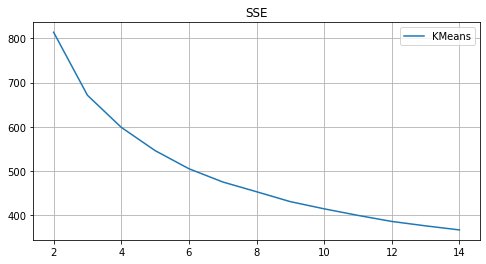

================ El valor de K es 7 ===================


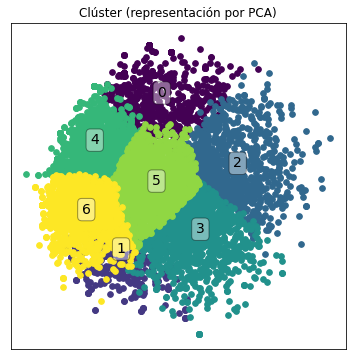

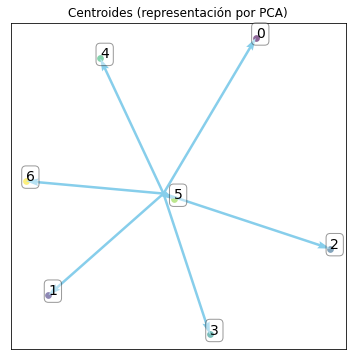

Cluster id:0, Numero de elementos: 724 
Cluster id:1, Numero de elementos: 700 
Cluster id:2, Numero de elementos: 1006 
Cluster id:3, Numero de elementos: 1395 
Cluster id:4, Numero de elementos: 1406 
Cluster id:5, Numero de elementos: 1975 
Cluster id:6, Numero de elementos: 1471 


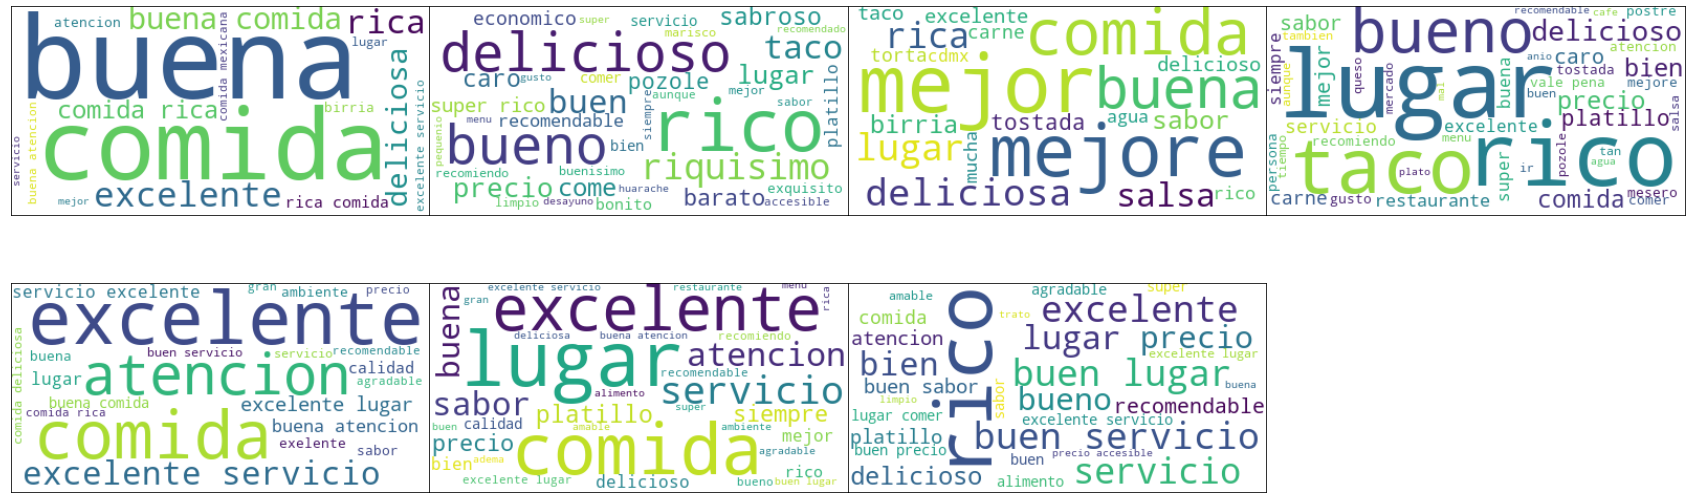

In [13]:
X_fast2=list(X_fast)
topicos=topicos_palabras(X_fast2,texto_limpio,K_min=7,omitir=[])
data["topicos"]=topicos.labels_

## Revisamos las reseñas más cercanas a cada centroide de cada cluster para inferir el tópico

In [14]:
aux=[]
for i in np.unique(data.topicos):
    aux.append(data[data["topicos"]==i].embeddings.to_numpy().mean())

In [15]:
text_topic(data,centroids=aux,top=5)


 Reseñas de cluster 0
1 Comida casera deliciosa.
2 Comida casera, rica y económico
3 Me encanta el concepto y la comida es deliciosa
4 Rica comida Yucateca con platillos de temporada
5 Riquísima comida típica oaxaqueña acompañada de un buen mezcal.

 Reseñas de cluster 1
1 Delicioso y económico
2 Bastante rico
3 Ricos antojitos.
4 Muy rico, original y costo razonable
5 Muy rico, original y costo razonable

 Reseñas de cluster 2
1 ¡muy buena birria de espaldilla de carnero; costilla asada con nopales, cebollas de cambray y frijoles de la olla; ricas quesadillas y jericallas..., mis únicas sugerencias: mejorar ventilación y disminuir temperatura de refrigeradores a 2 grados Celsius para que la cerveza esté bien fría 😎
2 El Chamorro de Boda está espectacular
3 exelente su sabor y su textura de la carne muy sabrosa, esas cebollas deliciosas en vinagre y orégano y su salsa roja para chuparse los dedos
4 Completamente impresionado descubriendo esta joya en el Centro Histórico!! No tenía ide

## Conclusiones

Con lo anterior podemos inferir los siguientes tópicos:

1. El clúster 0 habla de "buena comida"
2. El cluster 1 habla de algo "rico/delicioso"
3. El clúster 2 habla de la "mejor comida"
4. El clúster 3 habla de un "lugar bueno/rico"
5. El clúster 4 habla de la "excelente atención"
6. El clúster 5 habla de un "excelente lugar/comida"
7. El clúster 6 habla de un "rico/buen lugar/servicio"

Una vez identificados los tópicos, los siguientes pasos pueden tomar varias vertientes: por un lado, se pueden generar reportes específicos para cada restaurant con el objetivo de dar visibilidad sobre los puntos que más valora el comensal.

Por otro lado, se pueden identificar subtópicos, explorando cada uno de los cluster mediante un algoritmo jerárquico.

Además, se debe considerar que aunque los clúster parezcan muy similares, lo relevante de la técnica de _word embeddings_ es que permite capturar el contexto del corpus. Se puede experimentar al modificar las _stop words_ (para ignorar ciertas palabras que metan ruido) o bien realizar un prepocesamiento del texto más profundo.